In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(221)
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [ ]:
df = pd.read_csv('df1(18to20)win.csv',index_col='Month Wise',parse_dates=True)

In [ ]:
#Hiden layer 

In [ ]:

df.columns=['Vacation']
df.head()


,Vacation
Month Wise,
0,3.2
1,2.5
2,1.9
3,1.5
4,3.3


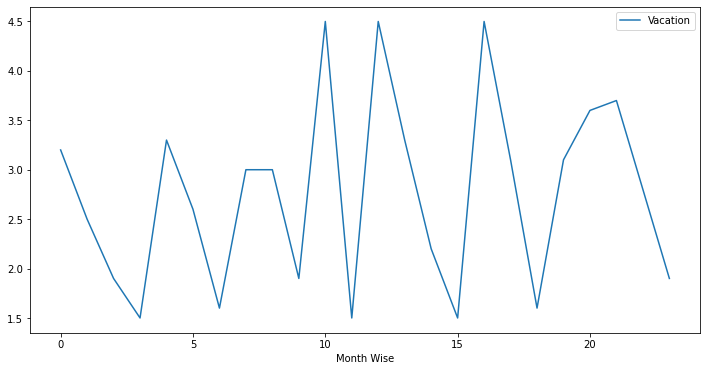

In [ ]:
df.plot(figsize=(12,6))

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


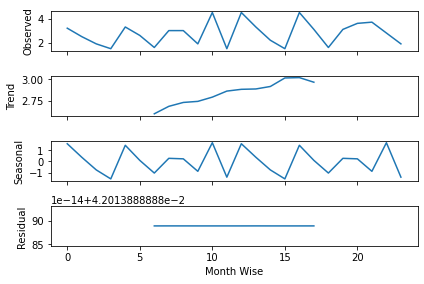

In [ ]:
results = seasonal_decompose(df['Vacation'],freq=12)
results.plot();

In [ ]:
len(df)

24

In [ ]:
train = df.iloc[:20]
test = df.iloc[20:]
test.head()

,Vacation
Month Wise,
20,3.6
21,3.7
22,2.8
23,1.9


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
df.head(),df.tail()

(            Vacation
 Month Wise          
 0                3.2
 1                2.5
 2                1.9
 3                1.5
 4                3.3,             Vacation
 Month Wise          
 19               3.1
 20               3.6
 21               3.7
 22               2.8
 23               1.9)

In [ ]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train[:10]

array([[0.56666667],
       [0.33333333],
       [0.13333333],
       [0.        ],
       [0.6       ],
       [0.36666667],
       [0.03333333],
       [0.5       ],
       [0.5       ],
       [0.13333333]])

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.56666667 0.33333333 0.13333333]
Predict this y: 
 [[0.]]


In [ ]:

X.shape

(1, 3, 1)

In [ ]:
 #for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=2)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# define model
#model = Sequential()
#model.add(LSTM(300, activation='relu', input_shape=(n_input, n_features)))#250#210
#model.add(Dense(1))
#model.compile(optimizer='Adam', loss='mse')

In [ ]:
model = Sequential()
model.add(LSTM(units =150, activation='relu', return_sequences=True,  input_shape=(n_input, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(units =50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units =20, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='Adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 150)           91200     
                                                                 
 dropout (Dropout)           (None, 12, 150)           0         
                                                                 
 lstm_1 (LSTM)               (None, 12, 50)            40200     
                                                                 
 dropout_1 (Dropout)         (None, 12, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 20)                5680      
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 2

In [ ]:
# fit model
model.fit(generator,epochs=1500)#45#250#350

Epoch 1/1500
4/4 [==============================] - 4s 22ms/step - loss: 0.3611
Epoch 2/1500
4/4 [==============================] - 0s 20ms/step - loss: 0.3179
Epoch 3/1500
4/4 [==============================] - 0s 24ms/step - loss: 0.2868
Epoch 4/1500
4/4 [==============================] - 0s 24ms/step - loss: 0.2121
Epoch 5/1500
4/4 [==============================] - 0s 23ms/step - loss: 0.1785
Epoch 6/1500
4/4 [==============================] - 0s 21ms/step - loss: 0.1432
Epoch 7/1500
4/4 [==============================] - 0s 22ms/step - loss: 0.1784
Epoch 8/1500
4/4 [==============================] - 0s 21ms/step - loss: 0.1968
Epoch 9/1500
4/4 [==============================] - 0s 26ms/step - loss: 0.1159
Epoch 10/1500
4/4 [==============================] - 0s 21ms/step - loss: 0.1664
Epoch 11/1500
4/4 [==============================] - 0s 23ms/step - loss: 0.1639
Epoch 12/1500
4/4 [==============================] - 0s 28ms/step - loss: 0.1484
Epoch 13/1500
4/4 [==================

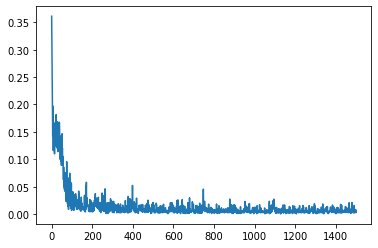

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
last_train_batch = scaled_train[-12:]

In [ ]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [ ]:
model.predict(last_train_batch)

array([[0.55285335]], dtype=float32)

In [ ]:
scaled_test[0]

array([0.7])

In [ ]:


test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)+24):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
test_predictions

[array([0.55285335], dtype=float32),
 array([0.6883062], dtype=float32),
 array([0.8372635], dtype=float32),
 array([0.44677144], dtype=float32),
 array([0.836121], dtype=float32),
 array([0.9388275], dtype=float32),
 array([0.2809286], dtype=float32),
 array([0.43295032], dtype=float32),
 array([0.8358461], dtype=float32),
 array([0.67131066], dtype=float32),
 array([0.04155624], dtype=float32),
 array([0.4136254], dtype=float32),
 array([0.4506805], dtype=float32),
 array([0.7851658], dtype=float32),
 array([0.9792548], dtype=float32),
 array([0.5262882], dtype=float32),
 array([0.9732848], dtype=float32),
 array([0.86473864], dtype=float32),
 array([0.28424695], dtype=float32),
 array([0.78544164], dtype=float32),
 array([0.99347967], dtype=float32),
 array([1.0001212], dtype=float32),
 array([0.06910944], dtype=float32),
 array([0.33335117], dtype=float32),
 array([0.40492275], dtype=float32),
 array([0.85941285], dtype=float32),
 array([0.98966974], dtype=float32),
 array([0.63317

In [ ]:
test.head()

,Vacation
Month Wise,
20,3.6
21,3.7
22,2.8
23,1.9


In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:

from IPython.core.pylabtools import figsize
new_df=pd.DataFrame(true_predictions)



In [ ]:
true_predictions,new_df

(array([[3.15856004],
        [3.56491864],
        [4.01179057],
        [2.84031433],
        [4.00836307],
        [4.31648254],
        [2.34278584],
        [2.79885095],
        [4.00753838],
        [3.51393199],
        [1.62466872],
        [2.74087617],
        [2.85204148],
        [3.85549736],
        [4.43776435],
        [3.07886463],
        [4.41985434],
        [4.09421593],
        [2.35274085],
        [3.85632491],
        [4.48043901],
        [4.50036371],
        [1.70732832],
        [2.5000535 ],
        [2.71476826],
        [4.07823855],
        [4.46900922],
        [3.39952719]]),            0
 0   3.158560
 1   3.564919
 2   4.011791
 3   2.840314
 4   4.008363
 5   4.316483
 6   2.342786
 7   2.798851
 8   4.007538
 9   3.513932
 10  1.624669
 11  2.740876
 12  2.852041
 13  3.855497
 14  4.437764
 15  3.078865
 16  4.419854
 17  4.094216
 18  2.352741
 19  3.856325
 20  4.480439
 21  4.500364
 22  1.707328
 23  2.500053
 24  2.714768
 25  4.078239
 26  

In [ ]:

true_predictions[-24:]#150 5.7

array([[4.00836307],
       [4.31648254],
       [2.34278584],
       [2.79885095],
       [4.00753838],
       [3.51393199],
       [1.62466872],
       [2.74087617],
       [2.85204148],
       [3.85549736],
       [4.43776435],
       [3.07886463],
       [4.41985434],
       [4.09421593],
       [2.35274085],
       [3.85632491],
       [4.48043901],
       [4.50036371],
       [1.70732832],
       [2.5000535 ],
       [2.71476826],
       [4.07823855],
       [4.46900922],
       [3.39952719]])

In [ ]:
true_predictions[-12:]#150 5.7Tanh

array([[4.41985434],
       [4.09421593],
       [2.35274085],
       [3.85632491],
       [4.48043901],
       [4.50036371],
       [1.70732832],
       [2.5000535 ],
       [2.71476826],
       [4.07823855],
       [4.46900922],
       [3.39952719]])

In [ ]:
  new_df.to_csv("LSTM F4(18-20).csv")

In [ ]:
  new_df.to_excel("LSTM F4(18-20).xlsx")

In [ ]:
true_predictions,new_df

(array([[4.53783174],
        [1.84188327],
        [1.62568493],
        [2.70437447],
        [4.50107714],
        [3.71890562],
        [2.92028866],
        [2.67238045],
        [2.71048601],
        [2.7640146 ],
        [2.62805008],
        [1.815605  ]]),            0
 0   4.537832
 1   1.841883
 2   1.625685
 3   2.704374
 4   4.501077
 5   3.718906
 6   2.920289
 7   2.672380
 8   2.710486
 9   2.764015
 10  2.628050
 11  1.815605)